<a href="https://colab.research.google.com/github/CaptnPogChamp10/mamun-haidar-ali.github.io/blob/main/Wide_field_imaging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

=== Wide-Field ODMR Image Processing Simulation ===
Demonstrating differential imaging pipeline...
Creating synthetic diamond sample...
Simulating ODMR measurement with 30 frequency points...
Progress: 0/30 (0.0%)
Progress: 10/30 (33.3%)
Progress: 20/30 (66.7%)
Simulating ODMR measurement with 30 frequency points...
Progress: 0/30 (0.0%)
Progress: 10/30 (33.3%)
Progress: 20/30 (66.7%)
Simulating ODMR measurement with 30 frequency points...
Progress: 0/30 (0.0%)
Progress: 10/30 (33.3%)
Progress: 20/30 (66.7%)


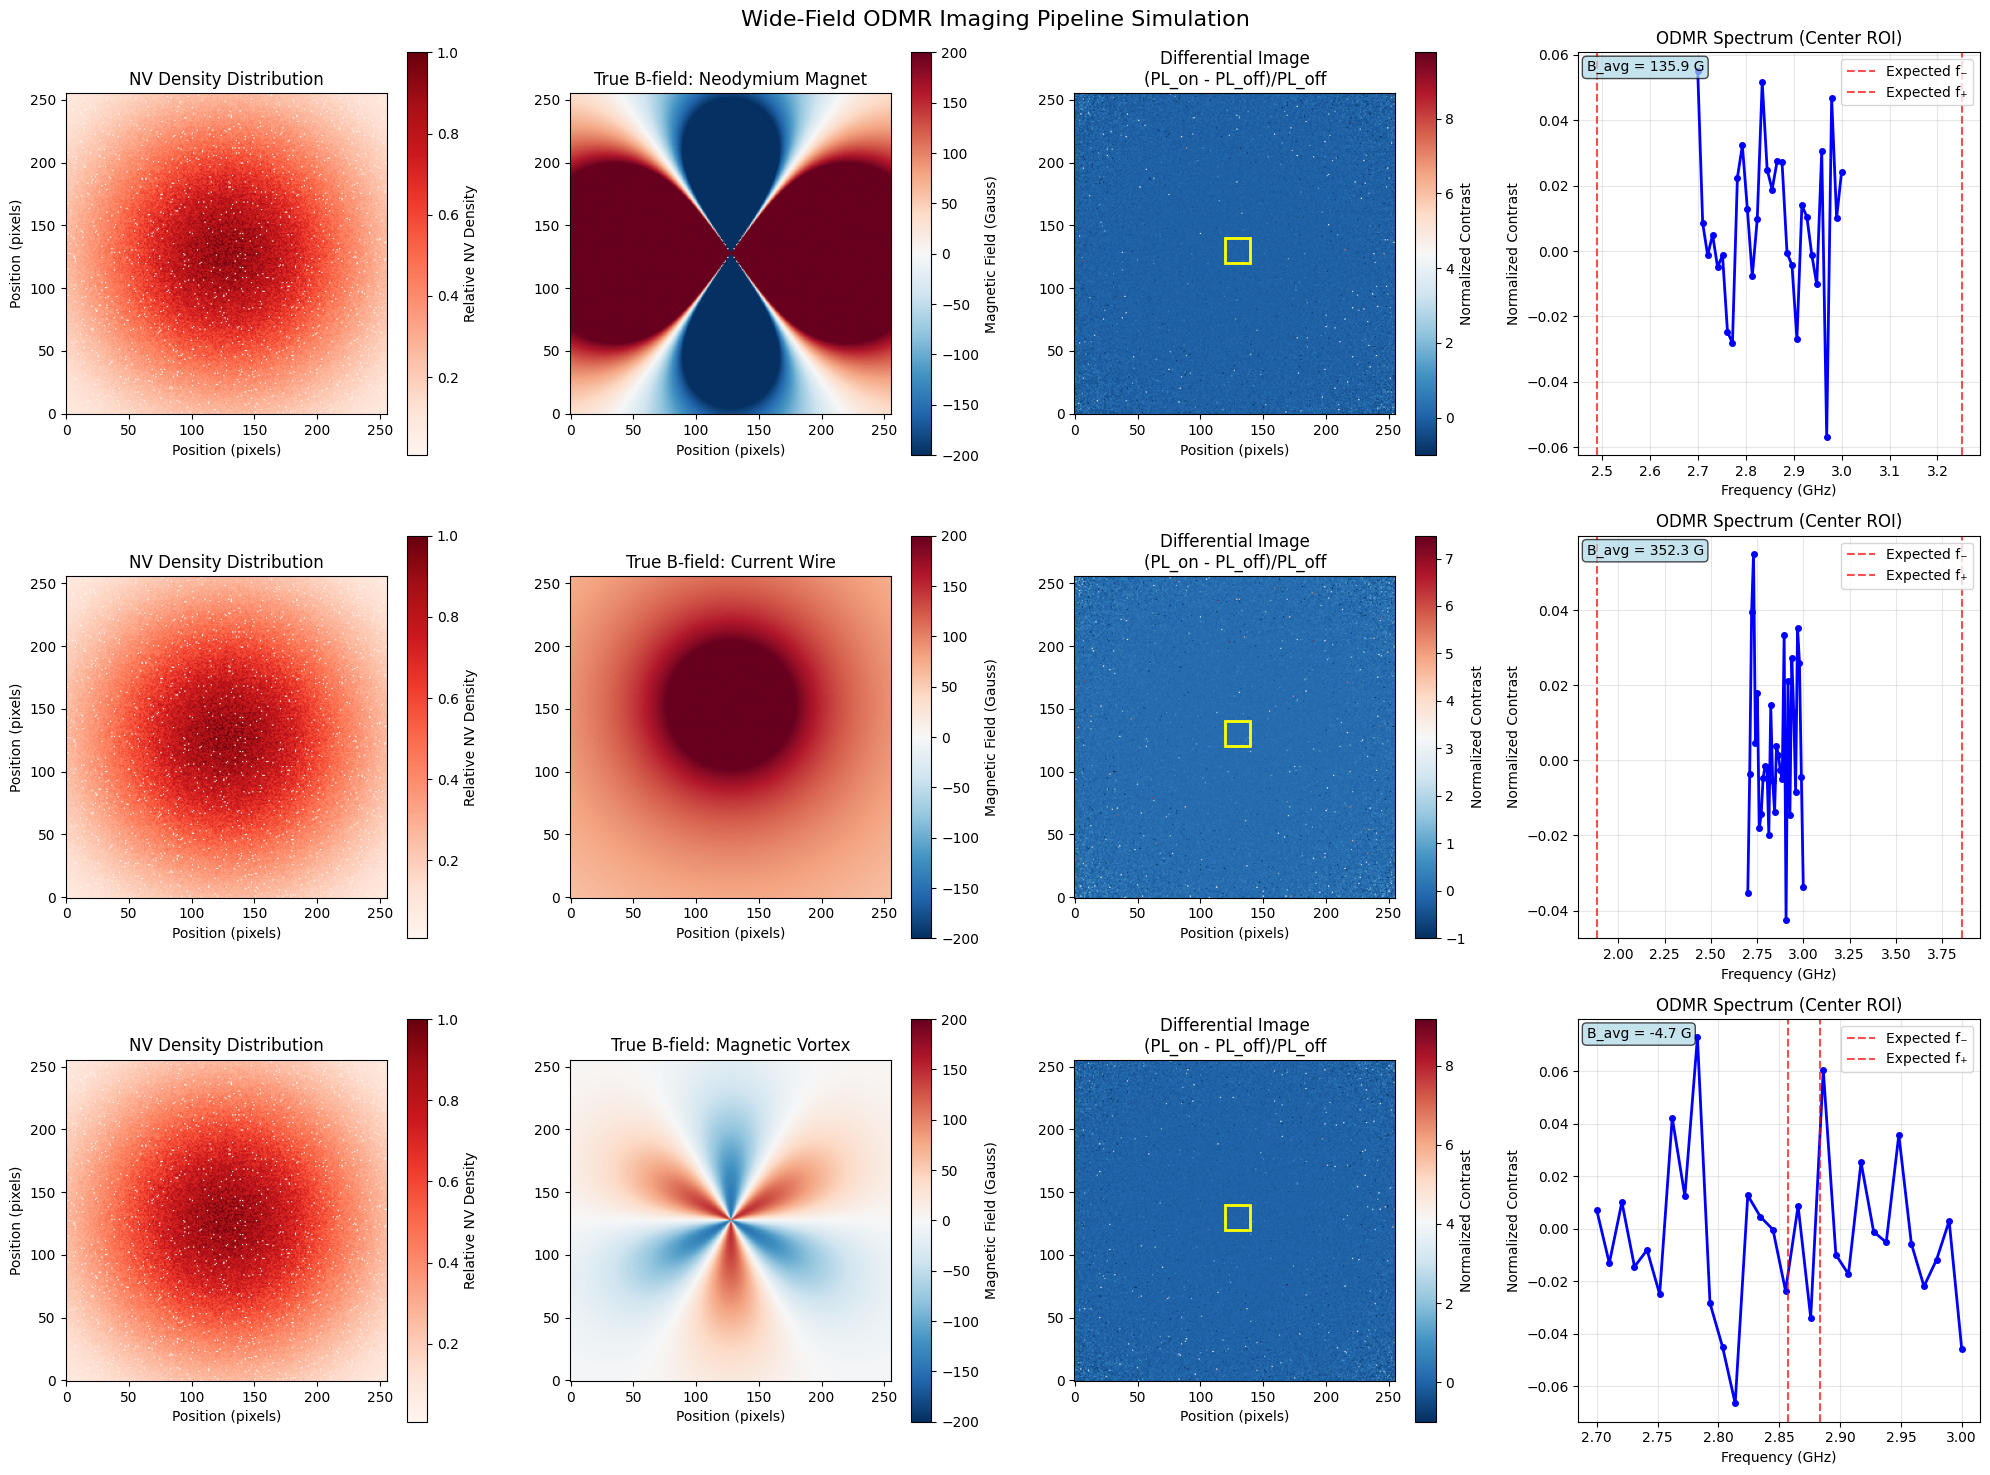


=== Imaging Pipeline Summary ===
Camera resolution: 2048×2048 pixels
Digital resolution: 65 nm/pixel
Field of view: 130000.00 mm²
Optical resolution: 486 nm
ODMR contrast: 1.73%
Linewidth: 6.37 MHz

Demonstrating ROI-based analysis...
Processing ROI 1: Top-Left
Simulating ODMR measurement with 20 frequency points...
Progress: 0/20 (0.0%)
Progress: 10/20 (50.0%)
  Average B-field: 275.3 G
Processing ROI 2: Top-Right
Simulating ODMR measurement with 20 frequency points...
Progress: 0/20 (0.0%)
Progress: 10/20 (50.0%)
  Average B-field: 275.3 G
Processing ROI 3: Bottom-Left
Simulating ODMR measurement with 20 frequency points...
Progress: 0/20 (0.0%)
Progress: 10/20 (50.0%)
  Average B-field: 275.3 G
Processing ROI 4: Bottom-Right
Simulating ODMR measurement with 20 frequency points...
Progress: 0/20 (0.0%)
Progress: 10/20 (50.0%)
  Average B-field: 275.3 G
Processing ROI 5: Center
Simulating ODMR measurement with 20 frequency points...
Progress: 0/20 (0.0%)
Progress: 10/20 (50.0%)
  Ave

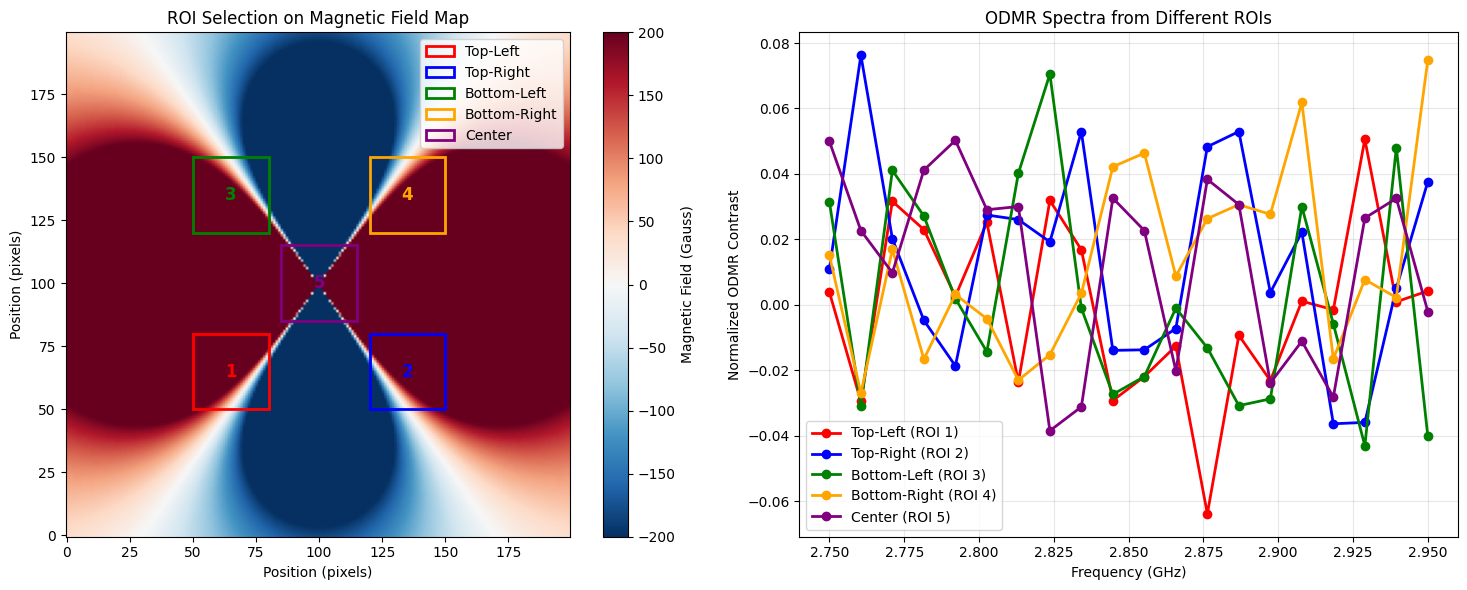

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage, optimize
from scipy.signal import find_peaks
import cv2
from matplotlib.patches import Rectangle
import matplotlib.patches as patches

class ODMRImageProcessor:
    """
    Simulates wide-field ODMR image processing pipeline based on the thesis:
    "Nitrogen-Vacancy-Based Diamond Wide-Field Magnetometer"

    Implements the differential imaging method: (PL_on - PL_off) / PL_off
    """

    def __init__(self):
        # Camera specifications from thesis (Hamamatsu CMOS)
        self.camera_params = {
            'pixel_count': (2048, 2048),
            'digital_resolution': 65e-9,  # 65 nm/pixel
            'field_of_view': 0.13e-6,     # 0.13 mm²
            'optical_resolution': 486e-9,  # 486 nm (diffraction limit)
            'bit_depth': 16
        }

        # Experimental parameters from thesis
        self.odmr_params = {
            'frequency_range': (2.6e9, 3.2e9),
            'contrast_widefield': 0.0173,    # 1.73%
            'linewidth': 6.37e6,             # 6.37 MHz
            'baseline_pl': 1000,             # Typical PL counts
            'noise_level': 0.05,             # 5% noise
            'laser_power_stability': 0.02,   # 2% laser fluctuation
            'mw_power_stability': 0.01       # 1% MW fluctuation
        }

        # Physical constants
        self.D_gs = 2.87e9       # Zero-field splitting
        self.gamma_e = 2.8e6     # Gyromagnetic ratio (Hz/Gauss)

    def create_synthetic_diamond_sample(self, size=(512, 512)):
        """
        Create a synthetic diamond sample with realistic NV distribution
        """
        # Base NV density with spatial variations
        x, y = np.meshgrid(np.linspace(0, 1, size[0]), np.linspace(0, 1, size[1]))

        # Simulate ion implantation profile (Gaussian + some inhomogeneity)
        nv_density = np.exp(-((x-0.5)**2 + (y-0.5)**2) / 0.2)

        # Add some random variations (crystal defects, implantation non-uniformity)
        nv_density += 0.3 * np.random.random(size) * nv_density

        # Add some "dead" regions (crystal damage)
        dead_spots = np.random.random(size) < 0.02
        nv_density[dead_spots] *= 0.1

        # Normalize to realistic range
        nv_density = nv_density / np.max(nv_density)

        return nv_density

    def create_magnetic_field_map(self, size=(512, 512), field_type='magnet'):
        """
        Create synthetic magnetic field distributions
        """
        x, y = np.meshgrid(np.linspace(-1, 1, size[0]), np.linspace(-1, 1, size[1]))

        if field_type == 'magnet':
            # Simulate 4x4 mm neodymium magnet from thesis
            # Dipole-like field with strong gradients
            r = np.sqrt(x**2 + y**2)
            theta = np.arctan2(y, x)

            # Simplified dipole field (Bz component)
            B_field = 200 * (3*np.cos(theta)**2 - 1) / (r**3 + 0.1)  # Gauss
            B_field = np.clip(B_field, -500, 500)  # Realistic range

        elif field_type == 'uniform':
            # Uniform field with small gradient
            B_field = 100 + 10*x + 5*y  # Gauss

        elif field_type == 'current_wire':
            # Magnetic field from current-carrying wire
            r = np.sqrt(x**2 + (y-0.2)**2)
            B_field = 100 / (r + 0.1)  # 1/r dependence

        elif field_type == 'vortex':
            # Magnetic vortex pattern
            r = np.sqrt(x**2 + y**2)
            theta = np.arctan2(y, x)
            B_field = 150 * np.exp(-r**2/0.5) * np.sin(3*theta)

        return B_field

    def simulate_pl_image(self, nv_density, B_field, frequency, mw_on=True):
        """
        Simulate photoluminescence image for given MW frequency
        """
        # Calculate Zeeman-split frequencies for each pixel
        f_minus = self.D_gs - self.gamma_e * B_field
        f_plus = self.D_gs + self.gamma_e * B_field

        # Base photoluminescence (proportional to NV density)
        pl_base = self.odmr_params['baseline_pl'] * nv_density

        if mw_on:
            # Calculate ODMR response at each pixel
            # Lorentzian lineshapes for both transitions
            contrast = self.odmr_params['contrast_widefield']
            linewidth = self.odmr_params['linewidth']

            # Response from ms=0 ↔ ms=-1 transition
            response_minus = contrast * (linewidth/2)**2 / ((frequency - f_minus)**2 + (linewidth/2)**2)

            # Response from ms=0 ↔ ms=+1 transition
            response_plus = contrast * (linewidth/2)**2 / ((frequency - f_plus)**2 + (linewidth/2)**2)

            # Total ODMR response (fluorescence decrease)
            odmr_response = response_minus + response_plus
            pl_image = pl_base * (1 - odmr_response)
        else:
            # MW off - just base fluorescence
            pl_image = pl_base

        # Add realistic noise sources
        # 1. Shot noise (Poisson)
        pl_image = np.random.poisson(pl_image).astype(float)

        # 2. Laser power fluctuations (affects entire image)
        laser_fluctuation = 1 + self.odmr_params['laser_power_stability'] * np.random.normal()
        pl_image *= laser_fluctuation

        # 3. Detector noise (Gaussian)
        detector_noise = np.random.normal(0, self.odmr_params['noise_level'] * np.mean(pl_image), pl_image.shape)
        pl_image += detector_noise

        # 4. Spatial non-uniformity (illumination, collection efficiency)
        x, y = np.meshgrid(np.linspace(-1, 1, pl_image.shape[0]), np.linspace(-1, 1, pl_image.shape[1]))
        spatial_variation = 1 + 0.1 * (x**2 + y**2)  # Slight vignetting
        pl_image *= spatial_variation

        return np.maximum(pl_image, 0)  # Ensure non-negative

    def differential_imaging(self, pl_on, pl_off, signal_averaging=1):
        """
        Implement differential imaging method: (PL_on - PL_off) / PL_off
        With signal averaging as mentioned in thesis
        """
        # Signal averaging (simulate SC repetitions from thesis)
        if signal_averaging > 1:
            pl_on_avg = np.zeros_like(pl_on)
            pl_off_avg = np.zeros_like(pl_off)

            for _ in range(signal_averaging):
                # Add slight variations between measurements
                noise_scale = 0.01
                pl_on_avg += pl_on * (1 + noise_scale * np.random.normal(size=pl_on.shape))
                pl_off_avg += pl_off * (1 + noise_scale * np.random.normal(size=pl_off.shape))

            pl_on = pl_on_avg / signal_averaging
            pl_off = pl_off_avg / signal_averaging

        # Differential normalization
        # Avoid division by zero
        pl_off_safe = np.maximum(pl_off, np.max(pl_off) * 0.01)

        differential_image = (pl_on - pl_off) / pl_off_safe

        return differential_image

    def extract_odmr_spectra(self, frequencies, B_field, nv_density, roi=None, signal_averaging=5):
        """
        Extract ODMR spectra from region of interest (ROI)
        Simulates the full measurement pipeline from thesis
        """
        if roi is None:
            # Use entire image
            roi_mask = np.ones_like(B_field, dtype=bool)
        else:
            # ROI format: (x_start, y_start, width, height)
            x_start, y_start, width, height = roi
            roi_mask = np.zeros_like(B_field, dtype=bool)
            roi_mask[y_start:y_start+height, x_start:x_start+width] = True

        odmr_spectrum = []

        print(f"Simulating ODMR measurement with {len(frequencies)} frequency points...")

        for i, freq in enumerate(frequencies):
            if i % 10 == 0:
                print(f"Progress: {i}/{len(frequencies)} ({100*i/len(frequencies):.1f}%)")

            # Simulate MW-on and MW-off images
            pl_on = self.simulate_pl_image(nv_density, B_field, freq, mw_on=True)
            pl_off = self.simulate_pl_image(nv_density, B_field, freq, mw_on=False)

            # Apply differential imaging
            diff_image = self.differential_imaging(pl_on, pl_off, signal_averaging)

            # Extract signal from ROI
            roi_signal = np.mean(diff_image[roi_mask])
            odmr_spectrum.append(roi_signal)

        return np.array(odmr_spectrum)

    def fit_odmr_pixel(self, frequencies, odmr_signal):
        """
        Fit ODMR spectrum for a single pixel to extract magnetic field
        """
        def double_lorentzian(f, f1, f2, gamma1, gamma2, A1, A2, offset):
            """Double Lorentzian for Zeeman-split peaks"""
            L1 = A1 * (gamma1/2)**2 / ((f - f1)**2 + (gamma1/2)**2)
            L2 = A2 * (gamma2/2)**2 / ((f - f2)**2 + (gamma2/2)**2)
            return offset - L1 - L2

        # Initial guess
        f_center = self.D_gs
        f_split = 10e6  # 10 MHz initial split guess
        p0 = [f_center - f_split/2, f_center + f_split/2, 5e6, 5e6, 0.01, 0.01, 0]

        try:
            popt, _ = optimize.curve_fit(double_lorentzian, frequencies, odmr_signal, p0=p0)
            f1, f2, gamma1, gamma2, A1, A2, offset = popt

            # Extract magnetic field from frequency splitting
            f_split_measured = abs(f2 - f1)
            B_field = f_split_measured / (2 * self.gamma_e)  # Convert to Gauss

            return B_field, popt
        except:
            return 0, p0  # Return zero field if fitting fails

    def create_magnetic_field_map_from_odmr(self, frequencies, nv_density, true_B_field, subsample=4):
        """
        Reconstruct magnetic field map from ODMR measurements
        Subsample to reduce computation time
        """
        h, w = nv_density.shape
        h_sub, w_sub = h//subsample, w//subsample

        B_reconstructed = np.zeros((h_sub, w_sub))

        print(f"Reconstructing {h_sub}x{w_sub} magnetic field map...")

        for i in range(h_sub):
            if i % 10 == 0:
                print(f"Row {i}/{h_sub}")

            for j in range(w_sub):
                # Define pixel ROI
                y_start = i * subsample
                x_start = j * subsample
                roi = (x_start, y_start, subsample, subsample)

                # Extract ODMR spectrum for this pixel region
                odmr_spectrum = self.extract_odmr_spectra(frequencies, true_B_field, nv_density, roi, signal_averaging=1)

                # Fit spectrum to extract magnetic field
                B_fitted, _ = self.fit_odmr_pixel(frequencies, odmr_spectrum)
                B_reconstructed[i, j] = B_fitted

        return B_reconstructed

def demonstrate_imaging_pipeline():
    """
    Demonstrate the complete wide-field ODMR imaging pipeline
    """
    processor = ODMRImageProcessor()

    # Create synthetic sample
    print("Creating synthetic diamond sample...")
    nv_density = processor.create_synthetic_diamond_sample(size=(256, 256))

    # Create different magnetic field patterns
    B_field_magnet = processor.create_magnetic_field_map(size=(256, 256), field_type='magnet')
    B_field_wire = processor.create_magnetic_field_map(size=(256, 256), field_type='current_wire')
    B_field_vortex = processor.create_magnetic_field_map(size=(256, 256), field_type='vortex')

    # Frequency sweep (reduced for demo speed)
    frequencies = np.linspace(2.7e9, 3.0e9, 30)  # 30 points instead of full sweep

    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    fig.suptitle('Wide-Field ODMR Imaging Pipeline Simulation', fontsize=16)

    magnetic_fields = [B_field_magnet, B_field_wire, B_field_vortex]
    field_names = ['Neodymium Magnet', 'Current Wire', 'Magnetic Vortex']

    for row, (B_field, field_name) in enumerate(zip(magnetic_fields, field_names)):

        # Column 1: NV density
        ax1 = axes[row, 0]
        im1 = ax1.imshow(nv_density, cmap='Reds', origin='lower')
        ax1.set_title(f'NV Density Distribution')
        ax1.set_xlabel('Position (pixels)')
        ax1.set_ylabel('Position (pixels)')
        plt.colorbar(im1, ax=ax1, label='Relative NV Density')

        # Column 2: True magnetic field
        ax2 = axes[row, 1]
        im2 = ax2.imshow(B_field, cmap='RdBu_r', origin='lower', vmin=-200, vmax=200)
        ax2.set_title(f'True B-field: {field_name}')
        ax2.set_xlabel('Position (pixels)')
        plt.colorbar(im2, ax=ax2, label='Magnetic Field (Gauss)')

        # Column 3: Sample ODMR images at resonance
        ax3 = axes[row, 2]
        resonant_freq = processor.D_gs  # On resonance
        pl_on = processor.simulate_pl_image(nv_density, B_field, resonant_freq, mw_on=True)
        pl_off = processor.simulate_pl_image(nv_density, B_field, resonant_freq, mw_on=False)
        diff_image = processor.differential_imaging(pl_on, pl_off)

        im3 = ax3.imshow(diff_image, cmap='RdBu_r', origin='lower')
        ax3.set_title(f'Differential Image\n(PL_on - PL_off)/PL_off')
        ax3.set_xlabel('Position (pixels)')
        plt.colorbar(im3, ax=ax3, label='Normalized Contrast')

        # Column 4: Extracted ODMR spectrum from center region
        ax4 = axes[row, 3]
        center_roi = (120, 120, 20, 20)  # Center 20x20 pixel region
        odmr_spectrum = processor.extract_odmr_spectra(frequencies, B_field, nv_density, center_roi, signal_averaging=3)

        ax4.plot(frequencies/1e9, odmr_spectrum, 'b.-', linewidth=2, markersize=8)
        ax4.set_xlabel('Frequency (GHz)')
        ax4.set_ylabel('Normalized Contrast')
        ax4.set_title(f'ODMR Spectrum (Center ROI)')
        ax4.grid(True, alpha=0.3)

        # Add ROI rectangle to differential image
        rect = Rectangle((center_roi[0], center_roi[1]), center_roi[2], center_roi[3],
                        linewidth=2, edgecolor='yellow', facecolor='none')
        ax3.add_patch(rect)

        # Calculate expected peak positions
        B_center = B_field[center_roi[1]:center_roi[1]+center_roi[3],
                          center_roi[0]:center_roi[0]+center_roi[2]]
        B_avg = np.mean(B_center)
        f_expected_minus = (processor.D_gs - processor.gamma_e * B_avg) / 1e9
        f_expected_plus = (processor.D_gs + processor.gamma_e * B_avg) / 1e9

        ax4.axvline(f_expected_minus, color='red', linestyle='--', alpha=0.7, label=f'Expected f₋')
        ax4.axvline(f_expected_plus, color='red', linestyle='--', alpha=0.7, label=f'Expected f₊')
        ax4.legend()

        # Add field strength text
        ax4.text(0.02, 0.98, f'B_avg = {B_avg:.1f} G', transform=ax4.transAxes,
                verticalalignment='top', fontsize=10,
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))

    plt.tight_layout()
    plt.show()

    # Print imaging statistics
    print("\n=== Imaging Pipeline Summary ===")
    print(f"Camera resolution: {processor.camera_params['pixel_count'][0]}×{processor.camera_params['pixel_count'][1]} pixels")
    print(f"Digital resolution: {processor.camera_params['digital_resolution']*1e9:.0f} nm/pixel")
    print(f"Field of view: {processor.camera_params['field_of_view']*1e12:.2f} mm²")
    print(f"Optical resolution: {processor.camera_params['optical_resolution']*1e9:.0f} nm")
    print(f"ODMR contrast: {processor.odmr_params['contrast_widefield']*100:.2f}%")
    print(f"Linewidth: {processor.odmr_params['linewidth']/1e6:.2f} MHz")

def demonstrate_roi_analysis():
    """
    Demonstrate ROI-based analysis with different selection methods
    """
    processor = ODMRImageProcessor()

    # Create sample and field
    nv_density = processor.create_synthetic_diamond_sample(size=(200, 200))
    B_field = processor.create_magnetic_field_map(size=(200, 200), field_type='magnet')

    # Define multiple ROIs
    rois = [
        (50, 50, 30, 30),    # Top-left
        (120, 50, 30, 30),   # Top-right
        (50, 120, 30, 30),   # Bottom-left
        (120, 120, 30, 30),  # Bottom-right
        (85, 85, 30, 30),    # Center
    ]

    roi_names = ['Top-Left', 'Top-Right', 'Bottom-Left', 'Bottom-Right', 'Center']
    colors = ['red', 'blue', 'green', 'orange', 'purple']

    # Frequency sweep
    frequencies = np.linspace(2.75e9, 2.95e9, 20)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Show ROIs on magnetic field map
    im = ax1.imshow(B_field, cmap='RdBu_r', origin='lower', vmin=-200, vmax=200)
    ax1.set_title('ROI Selection on Magnetic Field Map')
    ax1.set_xlabel('Position (pixels)')
    ax1.set_ylabel('Position (pixels)')
    plt.colorbar(im, ax=ax1, label='Magnetic Field (Gauss)')

    # Draw ROI rectangles
    for i, (roi, name, color) in enumerate(zip(rois, roi_names, colors)):
        rect = Rectangle((roi[0], roi[1]), roi[2], roi[3],
                        linewidth=2, edgecolor=color, facecolor='none', label=name)
        ax1.add_patch(rect)

        # Add ROI number
        ax1.text(roi[0] + roi[2]/2, roi[1] + roi[3]/2, str(i+1),
                ha='center', va='center', color=color, fontweight='bold', fontsize=12)

    ax1.legend()

    # Extract and plot ODMR spectra for each ROI
    for i, (roi, name, color) in enumerate(zip(rois, roi_names, colors)):
        print(f"Processing ROI {i+1}: {name}")
        odmr_spectrum = processor.extract_odmr_spectra(frequencies, B_field, nv_density, roi, signal_averaging=2)

        ax2.plot(frequencies/1e9, odmr_spectrum, 'o-', color=color, linewidth=2,
                label=f'{name} (ROI {i+1})', markersize=6)

        # Calculate expected peaks
        B_roi = B_field[roi[1]:roi[1]+roi[3], roi[0]:roi[0]+roi[2]]
        B_avg = np.mean(B_roi)
        print(f"  Average B-field: {B_avg:.1f} G")

    ax2.set_xlabel('Frequency (GHz)')
    ax2.set_ylabel('Normalized ODMR Contrast')
    ax2.set_title('ODMR Spectra from Different ROIs')
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    plt.tight_layout()
    plt.show()

# Run the demonstrations
if __name__ == "__main__":
    print("=== Wide-Field ODMR Image Processing Simulation ===")
    print("Demonstrating differential imaging pipeline...")
    demonstrate_imaging_pipeline()

    print("\n" + "="*60)
    print("Demonstrating ROI-based analysis...")
    demonstrate_roi_analysis()
